In [27]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

%matplotlib inline
 

stop_words = set(stopwords.words('english'))
stop_words.add(",")
stop_words.add(".")


example_sent = """This is a sample sentence,
                  showing off the stop words filtration."""
word_tokens = word_tokenize(example_sent)

In [2]:
filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
" ".join(filtered_sentence)

'sample sentence showing stop words filtration'

In [3]:
stop_words = set(stopwords.words('english'))
stop_words.add(",")
stop_words.add(".")

def clean_text(text: str) -> str:
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    return " ".join(filtered_sentence)

In [4]:
train = pd.read_csv("../data/preprocessed/train.csv")

In [5]:
train.head()

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording,fold
0,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,000e8c3c7ddb,The third wave was an experimentto see how peo...,0.205683,0.380538,3
1,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",0020ae56ffbf,They would rub it up with soda to make the sme...,-0.548304,0.506755,2
2,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,004e978e639e,"In Egypt, there were many occupations and soci...",3.128928,4.231226,1
3,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,005ab0199905,The highest class was Pharaohs these people we...,-0.210614,-0.471415,1
4,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,0070c9e7af47,The Third Wave developed rapidly because the ...,3.272894,3.219757,3


<Axes: >

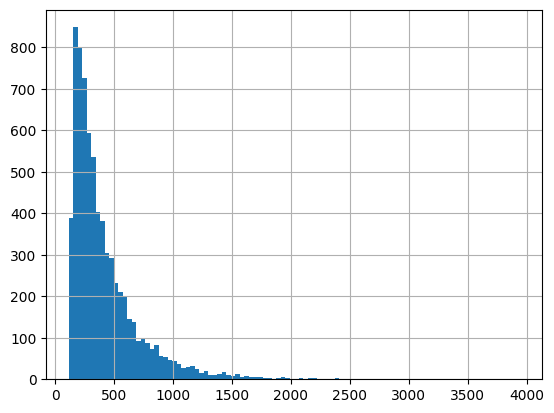

In [6]:
train["text"].str.len().hist(bins=100)

<Axes: >

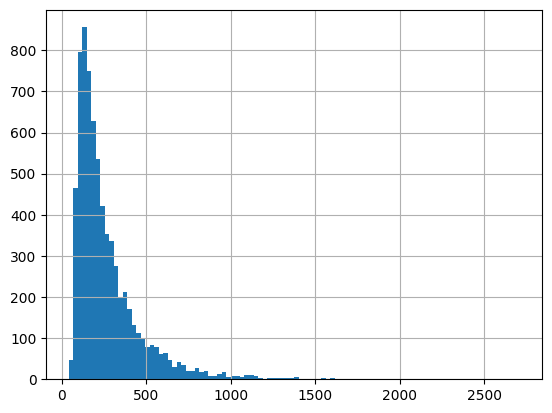

In [7]:
train["text"].apply(clean_text).str.len().hist(bins=100)

In [8]:
train["text"].str.len().describe()

count    7165.000000
mean      418.776971
std       307.833685
min       114.000000
25%       216.000000
50%       320.000000
75%       513.000000
max      3940.000000
Name: text, dtype: float64

In [9]:
train["text"].apply(clean_text).str.len().describe()

count    7165.000000
mean      267.357432
std       203.593043
min        42.000000
25%       136.000000
50%       203.000000
75%       327.000000
max      2708.000000
Name: text, dtype: float64

In [10]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')


In [11]:
prompt_ids = train["prompt_id"].unique()

for prompt_id in prompt_ids:
    is_this_prompt = train["prompt_id"] == prompt_id

    p_text = train.loc[is_this_prompt, "prompt_text"].unique().tolist()
    text = train.loc[is_this_prompt, "text"].tolist()

    p_text_vec = model.encode(p_text, normalize_embeddings=True)
    text_vec = model.encode(text, normalize_embeddings=True)

    cos_sim = cosine_similarity(p_text_vec, text_vec).ravel()

    train.loc[is_this_prompt, "cos_sim"] = cos_sim

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/65 [00:00<?, ?it/s]

<Axes: >

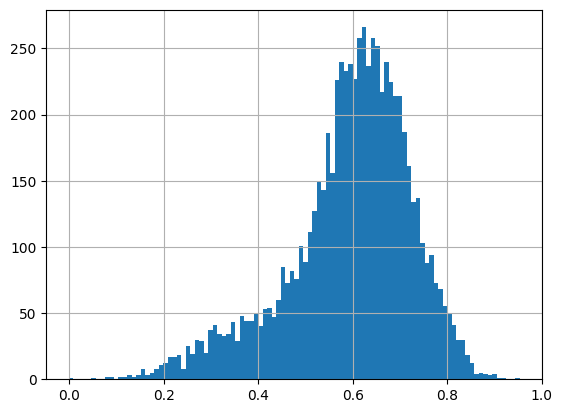

In [12]:
train["cos_sim"].hist(bins=100)

In [14]:
import gensim.downloader


model_name = "fasttext-wiki-news-subwords-300"
vectors = gensim.downloader.load(model_name)
vectors.most_similar('twitter')

[==================================================] 100.0% 958.5/958.4MB downloaded


[('Twitter', 0.8208357095718384),
 ('twitters', 0.8099667429924011),
 ('tweet', 0.7791348099708557),
 ('facebook', 0.7708378434181213),
 ('twitterer', 0.7670276165008545),
 ('twitter.', 0.7437460422515869),
 ('instagram', 0.739002525806427),
 ('twittering', 0.7377669215202332),
 ('twitterfeed', 0.7372092604637146),
 ('twitterati', 0.735425591468811)]

In [29]:
# TODO: preprocessing.py でモデル保存する
# vectors.save("fasttext-wiki-news-subwords-300.vectors")

In [23]:
words = train.loc[:5, "text"].apply(clean_text).str.split(" ")

In [48]:
def get_words_avg_vec(word: str):
    vec = []
    for w in words[0]:
        try:
            vec.append(vectors[w])
        except KeyError:
            pass
    return list(np.mean(vec, axis=0))


In [52]:
np.array([get_words_avg_vec(w) for w in words]).shape

(6, 300)